In [1]:
import numpy as np
import pandas as pd

### Exploritory Analysis

1. Perform Exploratory Data Analysis (EDA) and discuss the data and what you observe
prior to beginning modeling and how impact how to proceed

In [2]:
df = pd.read_csv("8k_diabetes_train.csv")

In [30]:
print(df.columns)

Index(['discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_diagnoses', 'max_glu_serum', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide.metformin',
       'glipizide.metformin', 'glimepiride.pioglitazone',
       'metformin.rosiglitazone', 'metformin.pioglitazone', 'change',
       'diabetesMed', 'readmitted', '2nd_diag', '3rd_diag', 'ai_response'],
      dtype='object')


In [8]:
df.shape

(8000, 40)

In [9]:
df.describe()

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,43.183375,1.391750,15.543375,0.280875,0.108375,7.027875
std,19.518187,1.709575,8.398151,1.075932,0.467608,2.019680
min,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,32.000000,0.000000,10.000000,0.000000,0.000000,5.000000
50%,44.000000,1.000000,14.000000,0.000000,0.000000,7.000000
75%,57.000000,2.000000,19.000000,0.000000,0.000000,9.000000
max,120.000000,6.000000,75.000000,36.000000,9.000000,9.000000


In [ ]:
print(df.info())

In [ ]:
print(df.isnull().sum())

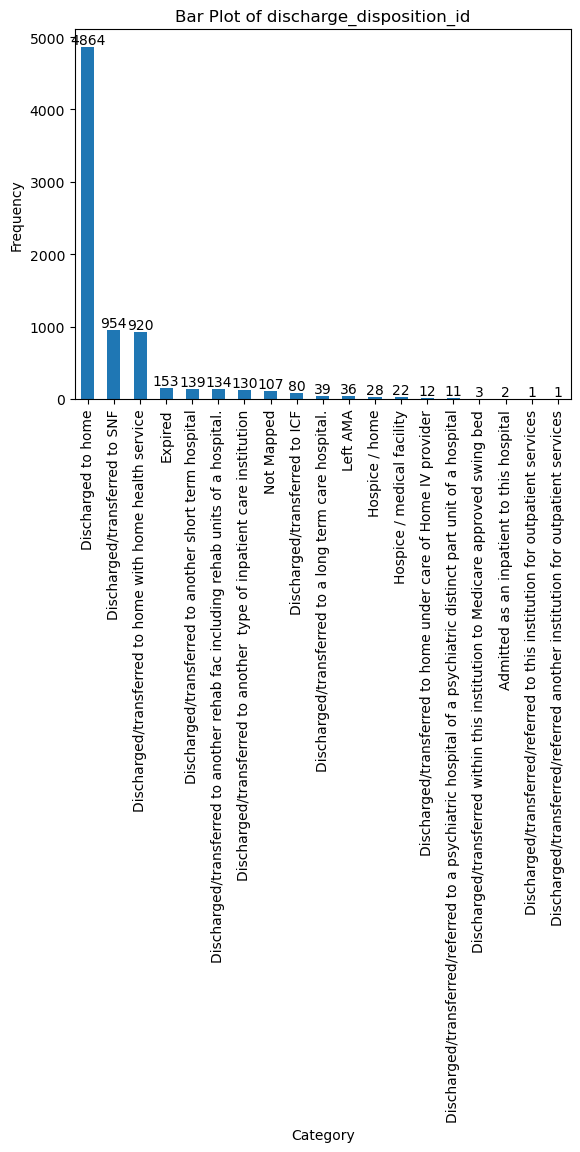

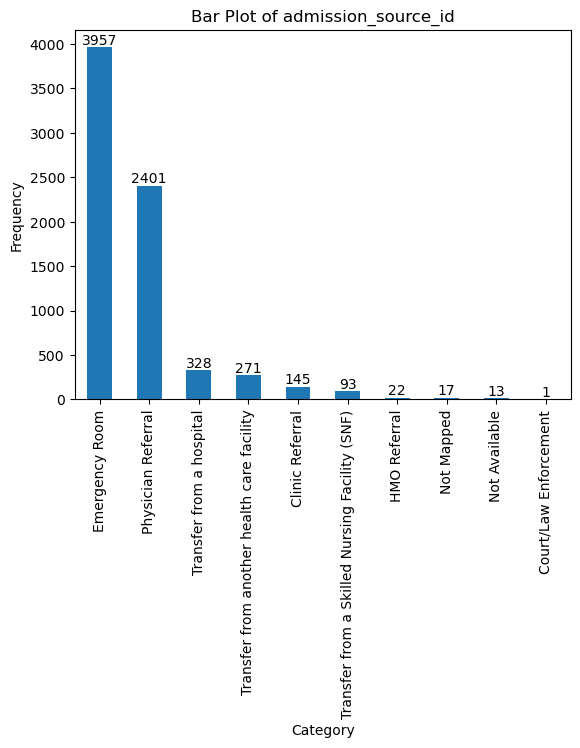

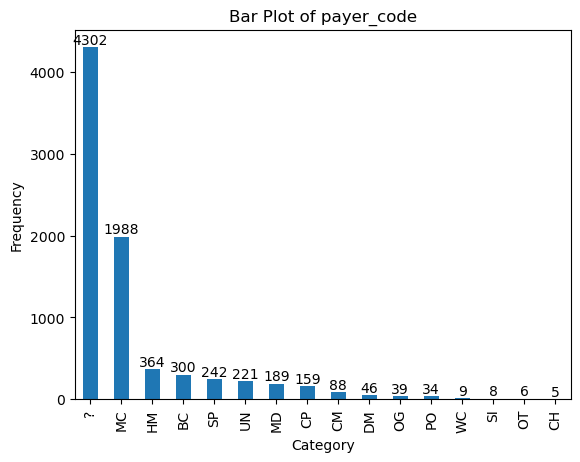

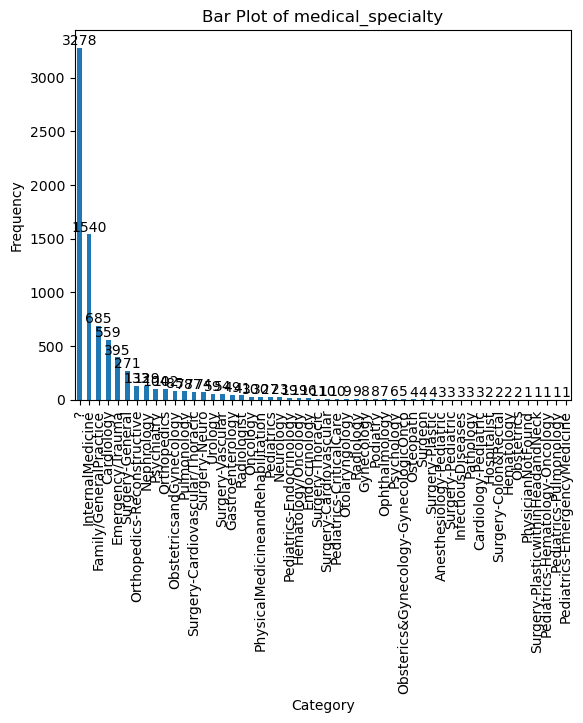

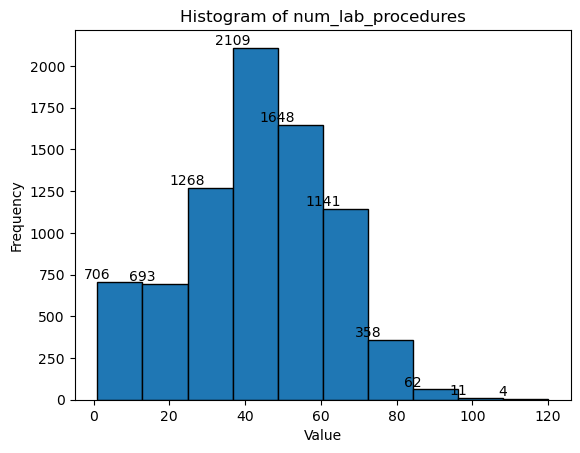

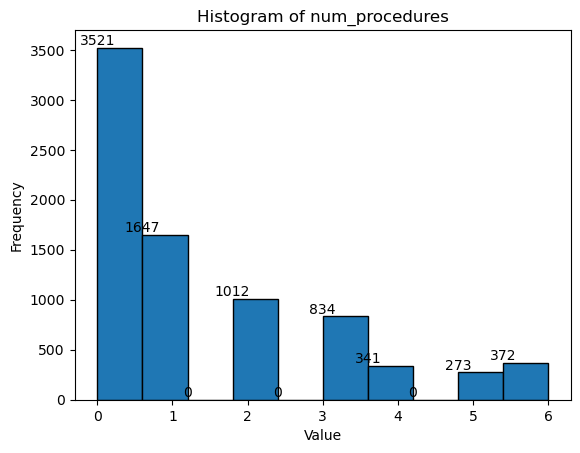

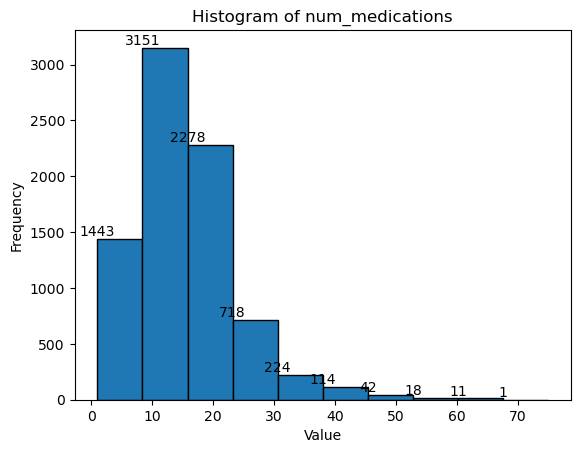

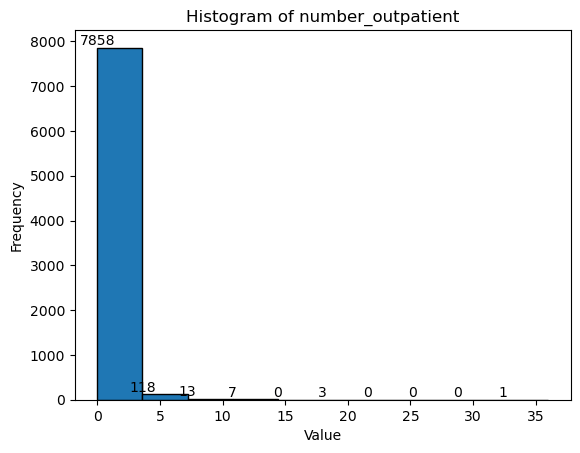

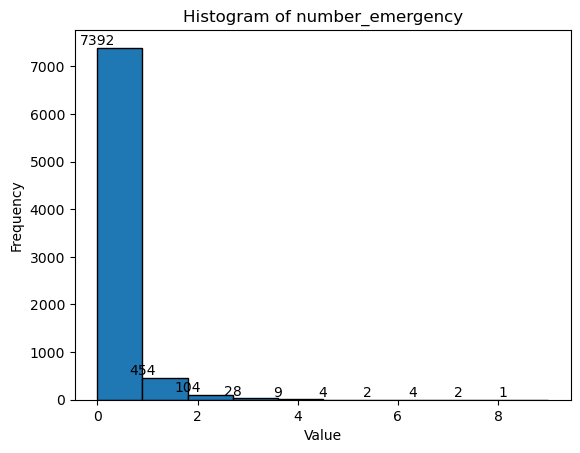

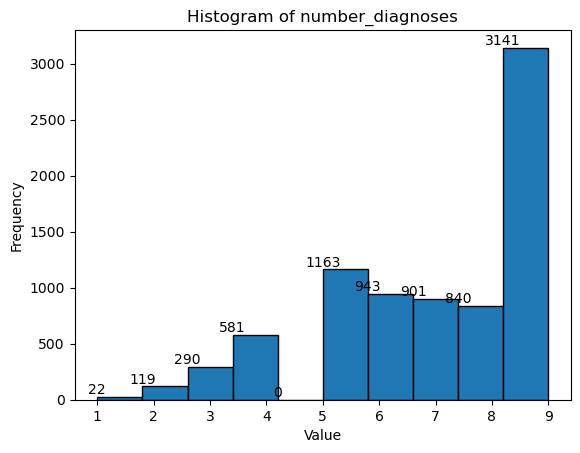

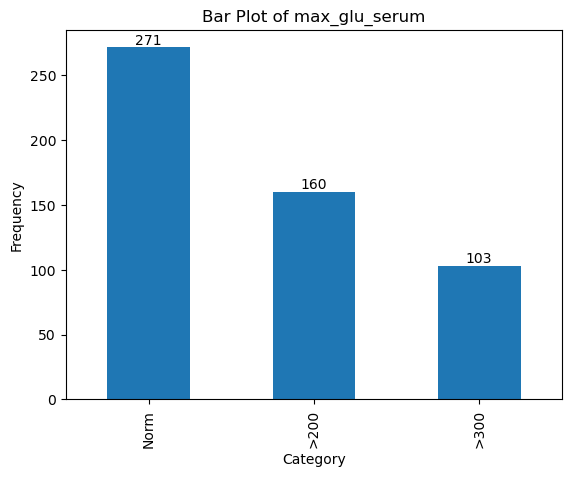

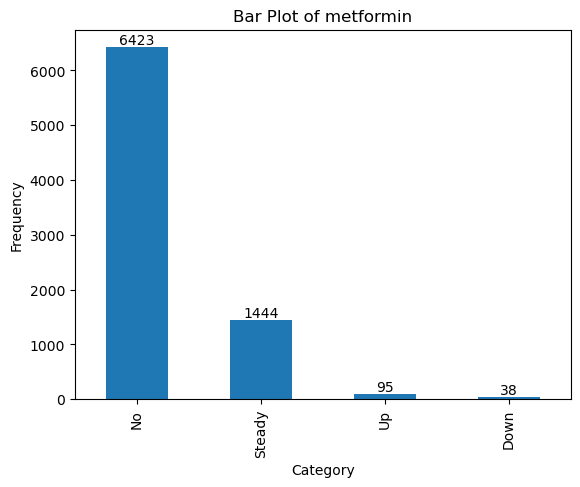

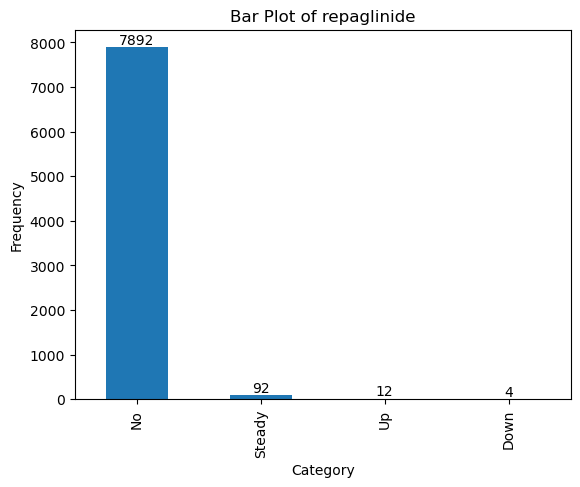

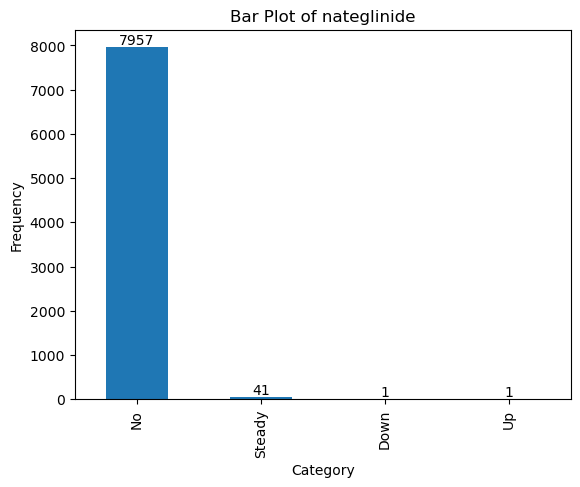

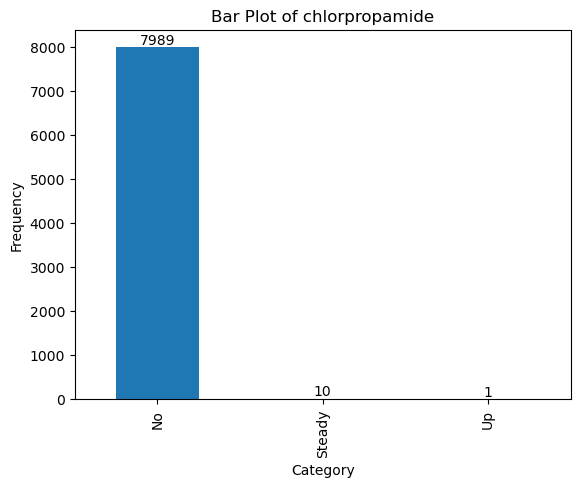

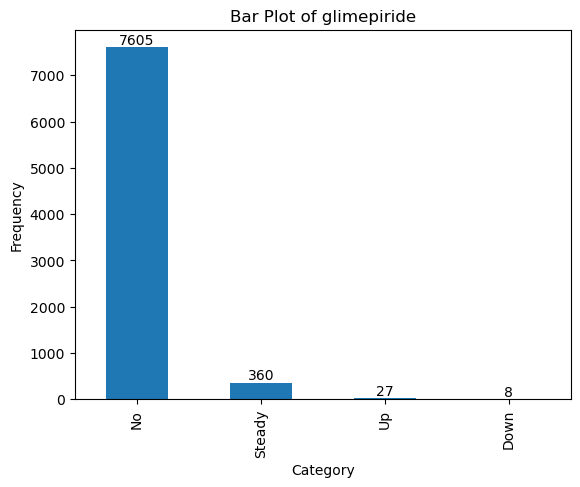

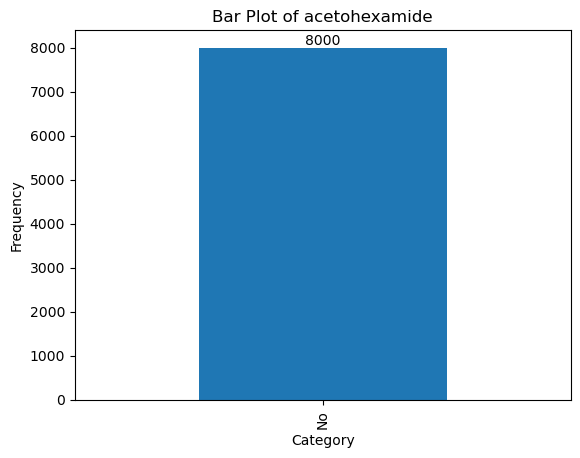

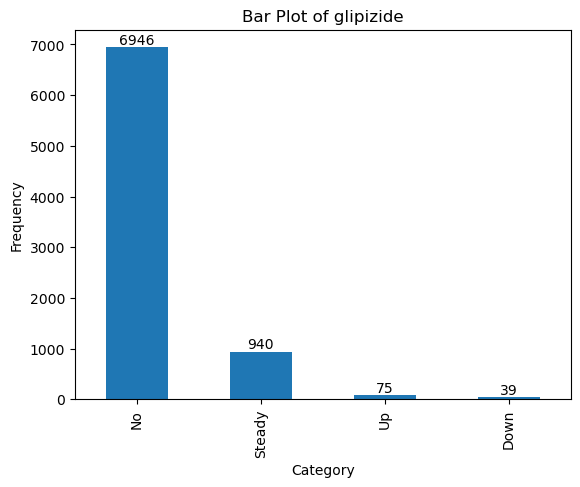

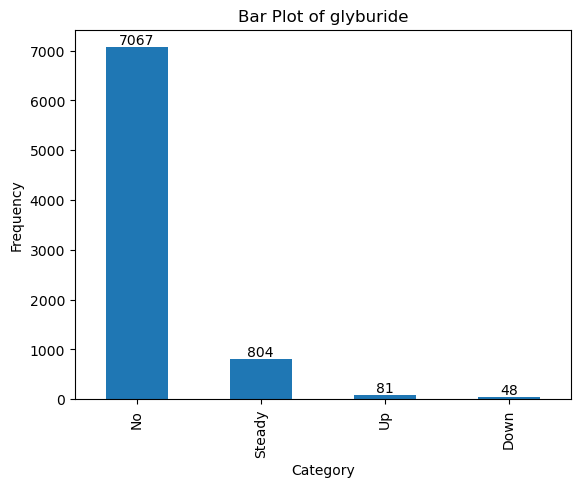

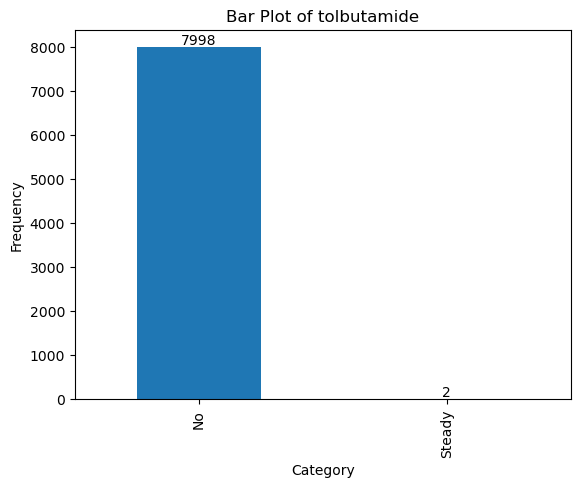

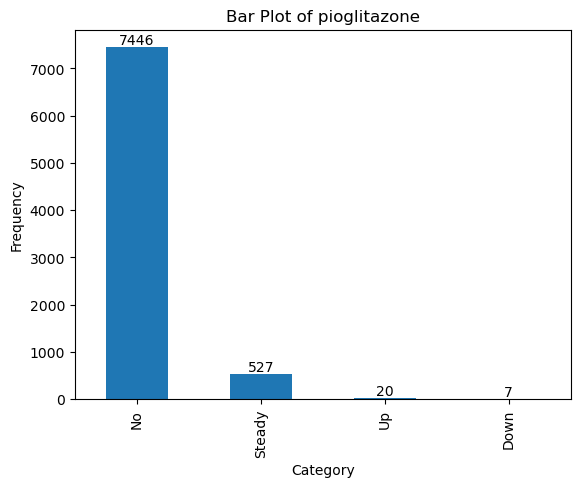

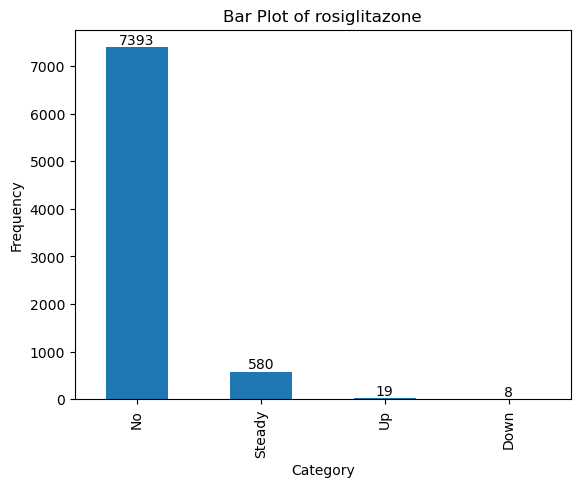

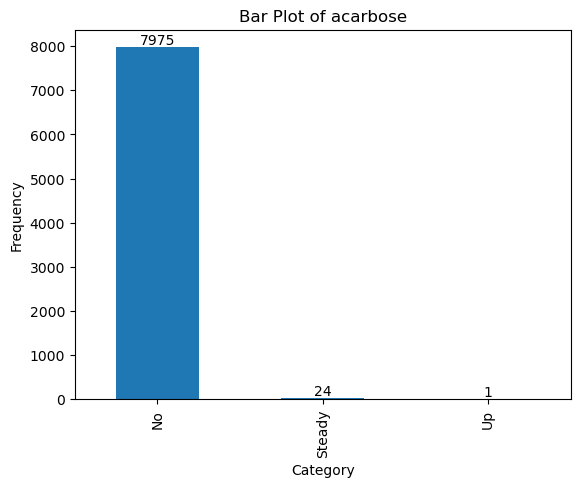

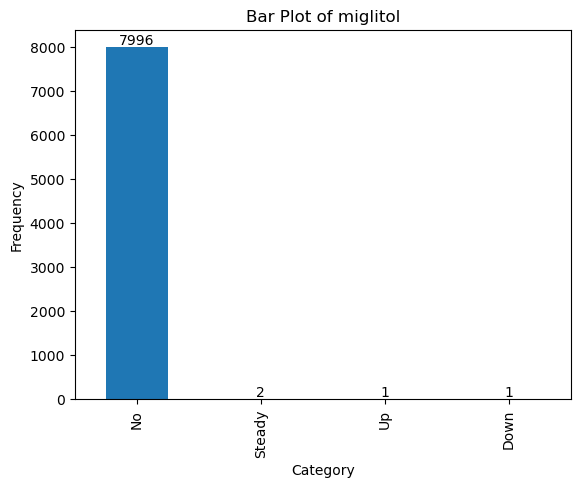

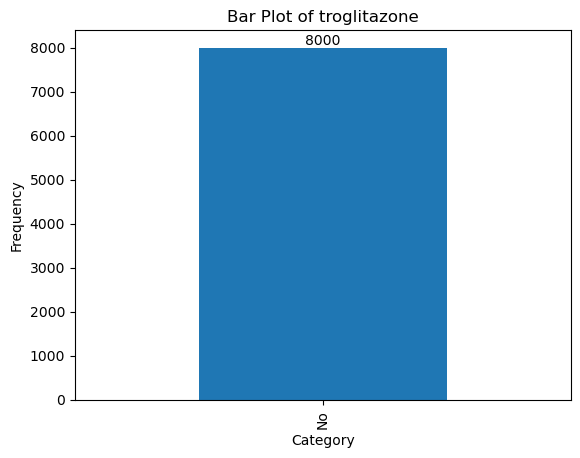

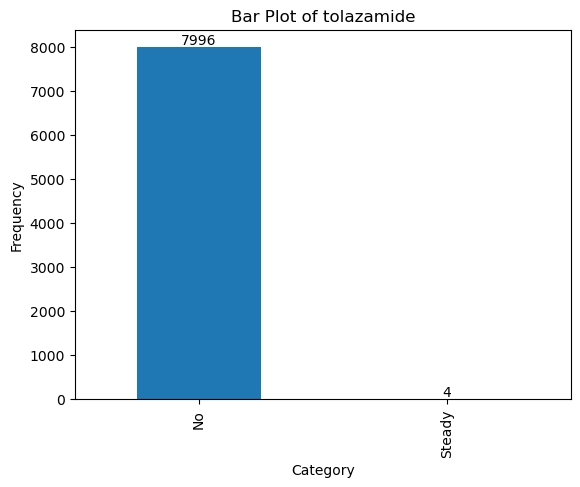

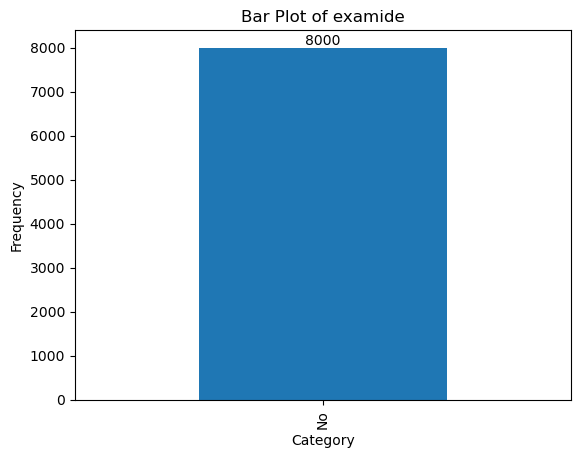

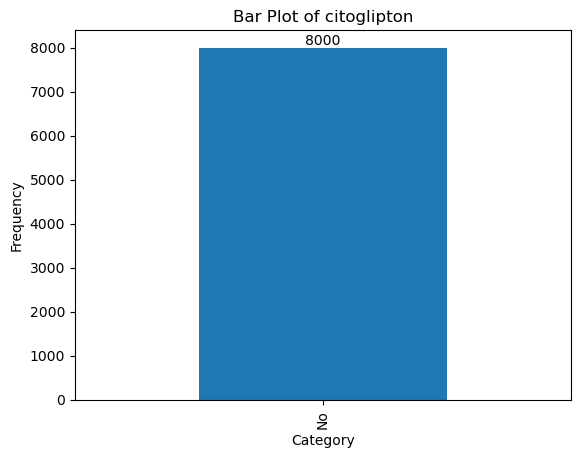

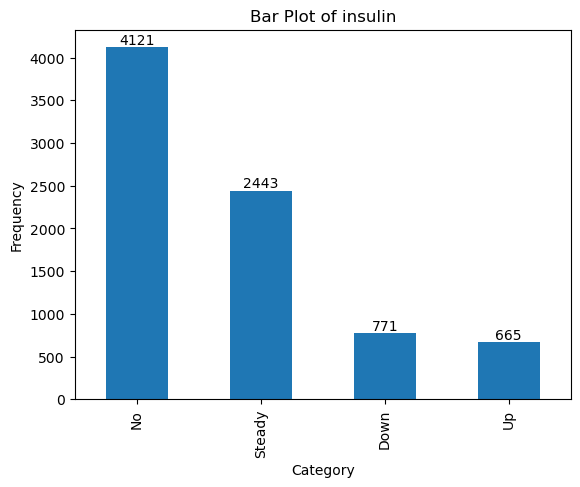

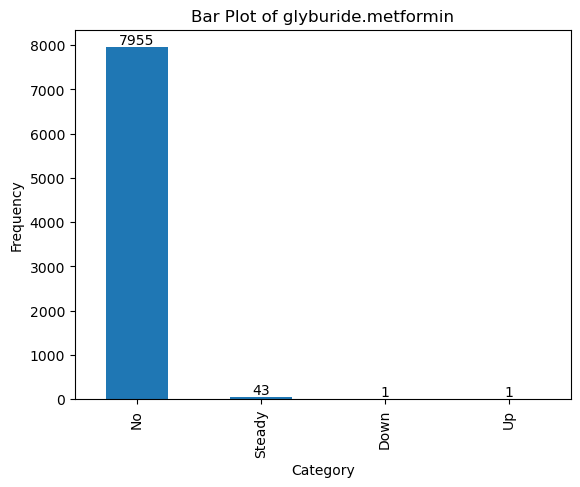

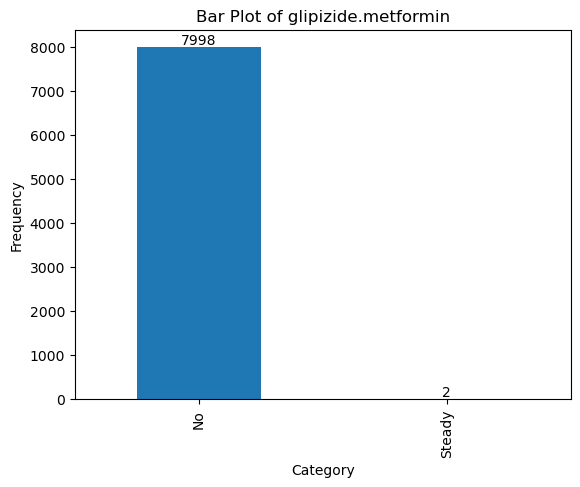

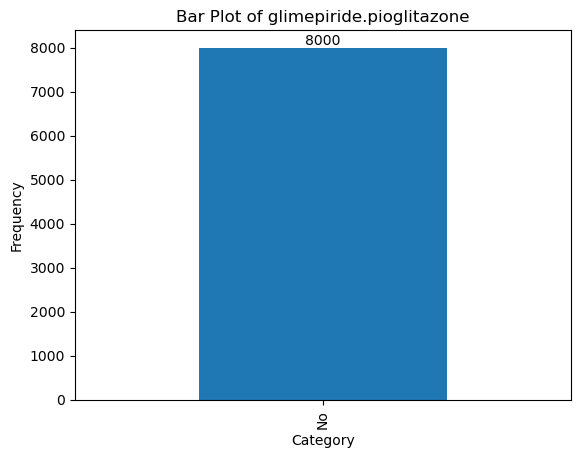

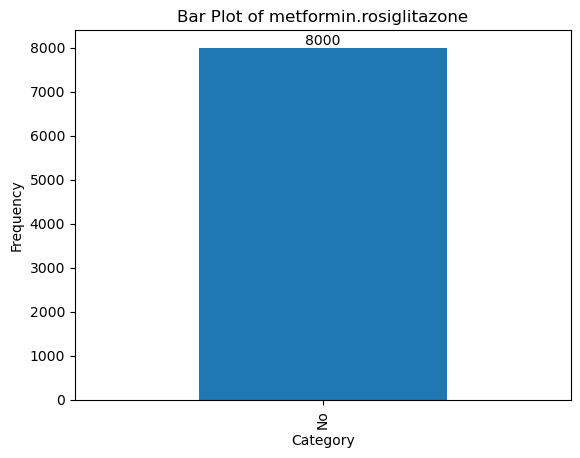

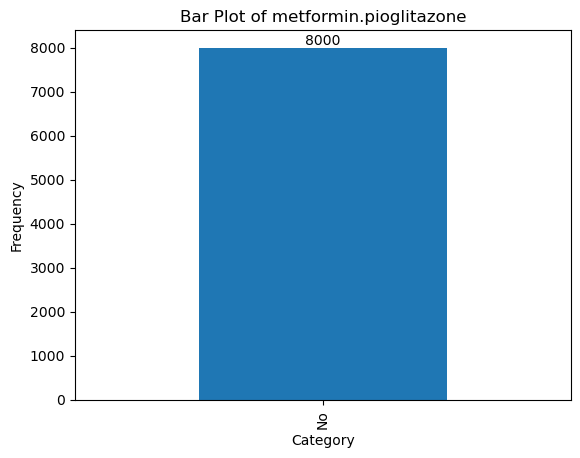

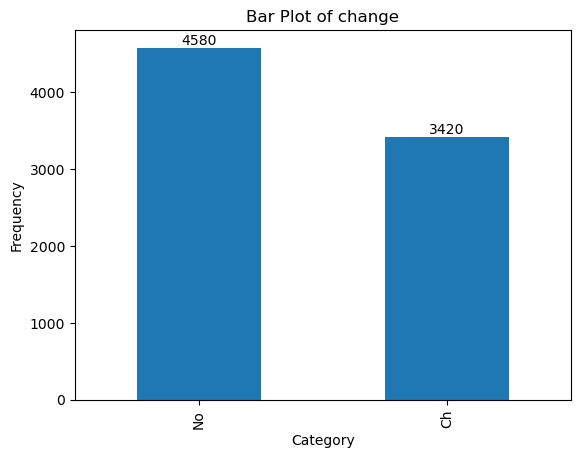

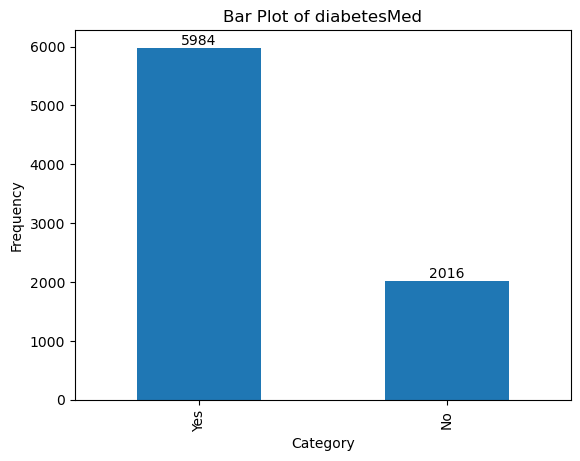

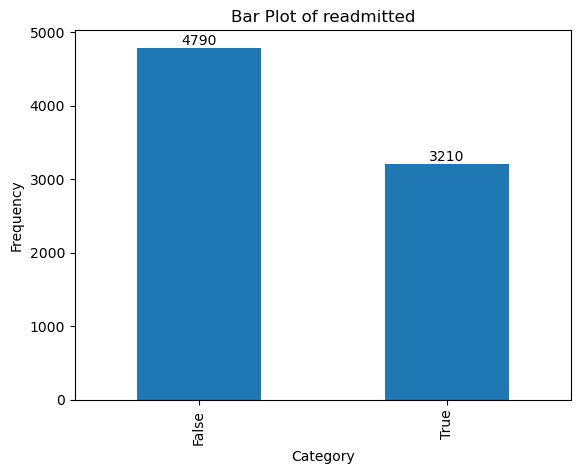

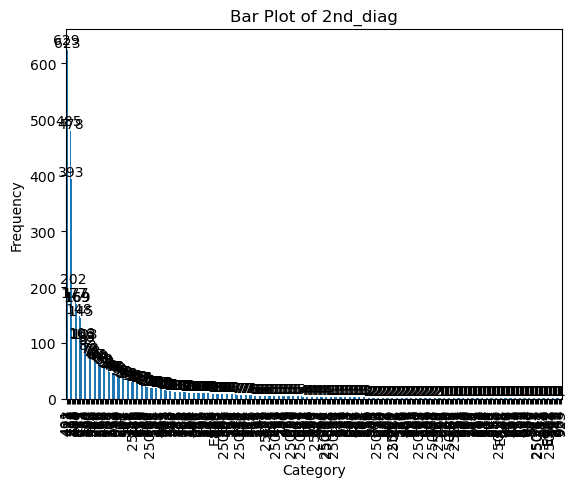

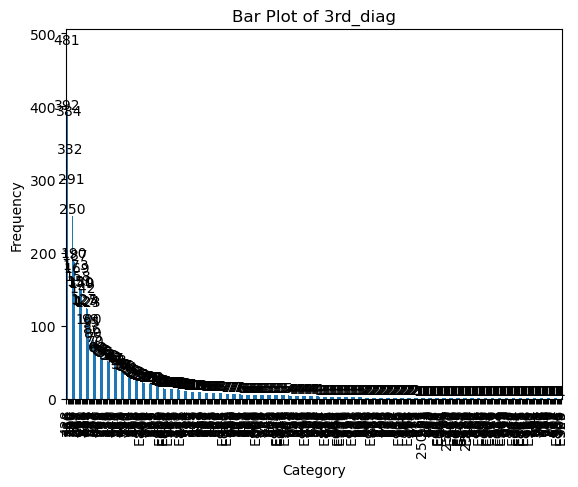

In [27]:
import matplotlib.pyplot as plt

# Iterate through each column in the DataFrame
for column in df.columns[:-1]:
    # Check the data type of the column
    dtype = df[column].dtype
    if dtype == 'int64' or dtype == 'float64':  # Numeric column
        plt.figure()  # Create a new figure
        counts, bins, _ = plt.hist(df[column], bins=10, edgecolor='black')  # Create a histogram
        plt.title(f'Histogram of {column}')  # Set the title
        plt.xlabel('Value')  # Set the x-axis label
        plt.ylabel('Frequency')  # Set the y-axis label

        # Add count labels
        for count, bin in zip(counts, bins):
            plt.text(bin, count, str(int(count)), ha='center', va='bottom')

        plt.show()  # Display the plot
        
    else:  # Categorical column
        plt.figure()  # Create a new figure
        value_counts = df[column].value_counts()
        value_counts.plot(kind='bar')  # Create a bar plot
        plt.title(f'Bar Plot of {column}')  # Set the title
        plt.xlabel('Category')  # Set the x-axis label
        plt.ylabel('Frequency')  # Set the y-axis label

        # Add count labels
        for i, v in enumerate(value_counts):
            plt.text(i, v, str(v), ha='center', va='bottom')

        plt.show()  # Display the plot

In [ ]:
pd.set_option('display.max_columns', None)
df.head(10)

In [ ]:
for column in df.columns:
    distinct_values = df[column].unique()
    print(f"Column '{column}' has {len(distinct_values)} distinct value(s):\n{distinct_values}\n")

After analyzing the data, there seems to be some features where it contains one value or seem to be the biggest majoirty. Dropping the columns containing one distnct value is necassary and dropping column with a very infrequent majority class seems needed as well. For columns with multiple distinguish classes, they will need to encoded. Aggregating infrequent classes into one "infrequent class" might be needed to avoid overfitting. There are some null values but might want to fill in multiple values to perserve dataset size. For columns with lots of missing values, will be dropped.

### Preprocess

In [3]:
todrop = ['max_glu_serum', 'acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'nateglinide', 'chlorpropamide', 'tolbutamide', 'acarbose', 'miglitol', 'tolazamide', 'glipizide.metformin']
final_df = df.drop(columns = todrop)
final_df.shape

(8000, 25)

Dropped max_glu_serum because it contains tremendous amounts of NULL values. Other features were dropped because it only contained 1 distinct value. For other features with more than 1 distinct value, columns were dropped if the total minority classes is than 30 to avoid overfitting

In [4]:
from sklearn.impute import SimpleImputer

# Specify the columns you want to impute
columns_to_impute = ['discharge_disposition_id', 'admission_source_id']

# Impute null values with mode for specified columns
imputer = SimpleImputer(strategy='most_frequent')
final_df[columns_to_impute] = imputer.fit_transform(final_df[columns_to_impute])

**3. Pre-processed numerical data appropriately including handling missing data and
justified methods used.**

I only normalized the data so that no feature scale wouldn't impact the performance of future models being runned.

In [5]:
from sklearn.preprocessing import StandardScaler

#standardize
scaler = StandardScaler()
numeric_cols = final_df.select_dtypes(include=['int', 'float']).columns

final_df[numeric_cols] = scaler.fit_transform(final_df[numeric_cols])

**2. Pre-processed categorical data for use in the model and justified pre-processing
method.**

An ordinal encoder was used for features with multiple classes so that computation wouldn't take to long and also to convert categorical data to numeric data. One hot encoding was used on feature with very few classes 1-4 since one hot encoding is effective since it assumes no hierarchy and that very few features were being made.

In [6]:
from sklearn.preprocessing import OrdinalEncoder

#ordinal endcoder
enc = OrdinalEncoder(min_frequency=(1/100))
ordinal_cols = ['discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', '2nd_diag', '3rd_diag']

final_df[ordinal_cols] = enc.fit_transform(final_df[ordinal_cols])

In [7]:
from sklearn.preprocessing import OneHotEncoder

#remaining categorical data
categorical_cols = [col for col in final_df.select_dtypes(include=['object']).columns
                    if col != 'ai_response' and col != ordinal_cols] 

#one hot encoder
ohe = OneHotEncoder(min_frequency = (1/100))
one_hot_encoded = ohe.fit_transform(final_df[categorical_cols])

# Convert the encoded data into a DataFrame with appropriate column names
encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

In [8]:
new_df = pd.concat([final_df[numeric_cols], final_df[ordinal_cols],final_df['readmitted'],final_df['ai_response'],encoded_df], axis=1)

In [37]:
pd.set_option('display.max_columns', None)

### Model with tf-idf

4. Implement a model to make predictions using text data using tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer to the documents and transform the documents into TF-IDF features
tfidf_Ai = tfidf_vectorizer.fit_transform(new_df['ai_response'])

# partition
X = tfidf_Ai
y = new_df['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# model
log_classifier = LogisticRegression()
log_classifier.fit(X_train, y_train)

# prediction
y_pred = log_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred)) #accuracy

### Model Stacking with tf-idf

5. Use model stacking to incorporate tf-idf predictions for the text field
(diag_desc_combined) in the downstream algorithm

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# list models to use
rf_model = RandomForestClassifier(max_depth=4, random_state=50)
lr_model = LogisticRegression()
gb_model = GradientBoostingClassifier()

# function to predict
def get_model_predictions(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

# obtain predictions
rf_pred = get_model_predictions(rf_model, X_train, y_train, X_test)
lr_pred = get_model_predictions(lr_model, X_train, y_train, X_test)
gb_pred = get_model_predictions(gb_model, X_train, y_train, X_test)

# accuracy of each
accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", accuracy)
accuracy = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", accuracy)
accuracy = accuracy_score(y_test, gb_pred)
print("Gradient Boost Accuracy:", accuracy)

# combine predicted into meta data
meta_X = np.column_stack((rf_pred, lr_pred, gb_pred))

# use final prediction model on meta data
meta_model = LogisticRegression()
meta_model.fit(meta_X, y_test)

final_predictions = meta_model.predict(meta_X)

In [ ]:
# accuracy of model on meta data
accuracy = accuracy_score(y_test, final_predictions)
print("Stacked Model Accuracy:", accuracy)

#### Combining tf-idf with dataset

In [ ]:
# Convert TF-IDF features to DataFrame
tfidf_df = pd.DataFrame(tfidf_Ai.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate TF-IDF features with non-text data
combined_data = pd.concat([new_df.reset_index(drop=True), tfidf_df], axis=1)

In [ ]:
combined_data.shape

### Testing with multiple experiments

6. Perform experimentation for multiple modeling algorithms and justify why you
selected the experiments you chose

- Logistic regression is used because the predictor is binary and logistic regression utilizes a sigmoid function to classify a binary class.
    - Common penalties are used to test multiple experiemnts
- Random forest is used because I wanted to classify using 'readmitted' but don't want to use all the features to avoid expensive computation and overfitting. 
    - Since there are 48 features being used, I set the max_depth at least 15 to utilize some of them, though this might overfit
    - Minimum splits were set to [5,10,15] to avoid potential uninformative splits. 
    - Gini and entropy were used as common methods to measure purity
- Gradient Boosting is used because of how effective it is to avoid overfitting in a ensemble learning setting.
    - Similar to random forest, similar parameters will be used except different learning rates will be used
    - XGBoost is used to compare the effectiveness of both (randomly chosen weights are used)
    - Lowered max_depth since both decrease in accuracy

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

In [10]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [11]:
X = new_df.drop(columns = ['ai_response', 'readmitted']) # for compuatation I'll ignore the tf-idf columns
y = df.loc[:, ['readmitted']]

# Reshape y to a 1-dimensional array
y = np.ravel(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [13]:
# Setup KFold
kf = KFold(n_splits=4, shuffle=True, random_state=50)  

In [43]:
# Logistic Regression cross-validation
obj = LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000, l1_ratio=0.5)
log_reg_scores = cross_val_score(obj, X, y, cv=kf, scoring='accuracy')
print("Average Accuracy:", np.mean(log_reg_scores))

Average Accuracy: 0.614125


In [44]:
obj2 = RandomForestClassifier(n_estimators = 1000, max_depth = 5)
rand_forest_scores = cross_val_score(obj2, X_train, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy:", np.mean(rand_forest_scores))

Average Accuracy: 0.6178125


In [ ]:
obj2.fit(X_train, y_train)
y_pred_proba = obj2.predict_proba(X_test)[:,1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

In [14]:
obj3 = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 1000)
XG_boost_scores = cross_val_score(obj3, X_train, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy:", np.mean(XG_boost_scores))

obj3.fit(X_train, y_train)

y_pred_proba = obj3.predict_proba(X_test)[:, 1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

Average Accuracy: 0.63234375
ROC AUC Score: 0.6584018112238211


In [15]:
obj3 = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 1000)
XG_boost_scores = cross_val_score(obj3, X_train, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy:", np.mean(XG_boost_scores))

obj3.fit(X_train, y_train)

y_pred_proba = obj3.predict_proba(X_test)[:, 1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

Average Accuracy: 0.6296875
ROC AUC Score: 0.6543750491468112


In [16]:
obj3 = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 1000)
XG_boost_scores = cross_val_score(obj3, X_train, y_train, cv=kf, scoring='accuracy')
print("Average Accuracy:", np.mean(XG_boost_scores))

obj3.fit(X_train, y_train)

y_pred_proba = obj3.predict_proba(X_test)[:, 1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

Average Accuracy: 0.6296875
ROC AUC Score: 0.6543750491468112


In [ ]:
obj3.fit(X_train, y_train)

y_pred_proba = obj3.predict_proba(X_test)[:, 1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

Model stacking

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

base_models = [
    ('log_reg',LogisticRegression(penalty = 'elasticnet', solver='saga', max_iter=10000, l1_ratio=0.5)),
    ('rand_forest', RandomForestClassifier(n_estimators = 1000, max_depth = 5)),
]

stack_model = StackingClassifier(estimators=base_models, final_estimator=XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 1000))

In [ ]:
stack_model.fit(X_train, y_train)

# Evaluate the stacking model
stack_preds = stack_model.predict(X_test)
auc_score = roc_auc_score(y_test, stack_preds)
print("ROC AUC Score:", auc_score)

In [ ]:
from sklearn.model_selection import KFold

def sFold(folds, data, labels, model, model_args):
    kf = KFold(n_splits=folds)
    accuracies = []

    for train_index, test_index in kf.split(data):
        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        
        # Instantiate the model
        model.set_params(**model_args)

        # Fit the model
        model.fit(X_train,y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate accuracy as metric
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    average_accuracy = np.mean(accuracies)
    return average_accuracy

In [ ]:
df_fold = pd.DataFrame([], columns=['Experiment_Name', 'Penalty', 'Average_Accuracy']) # data frame of accuracy for each experiment
penalties = [0, 0.5, 1]
obj = LogisticRegression(solver='saga', max_iter=10000)

for i in penalties:
    params = {'penalty': 'elasticnet', 'l1_ratio': i} # set parameters
    average_error = sFold(3, X, y, obj, params) # obtain average accuracy
    df_fold = df_fold.append({'Experiment_Name': 'Logistic Regression', 'Penalty': i, 'Average_Accuracy': average_error}, ignore_index=True) # add to data frame 
df_fold

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import warnings

df_fold = pd.DataFrame([], columns=['Experiment_Name', 'Depth', 'Criterion', 'Min_Samples_Split', 'Average_Accuracy'])
depths = [15, 16, 17]
criteria = ['gini', 'entropy']
min_samples_splits = [15, 20, 25]
random_state = 50

for depth in depths:
    for criterion in criteria:
        for min_samples_split in min_samples_splits:
            model_args = {'max_depth': depth, 'criterion': criterion, 'min_samples_split': min_samples_split}
            obj = RandomForestClassifier(random_state=random_state)
            average_accuracy = sFold(5, X, y, obj, model_args)  # Assuming X and y are defined
            df_fold = df_fold.append({
                'Experiment_Name': 'Random Forest',
                'Depth': depth,
                'Criterion': criterion,
                'Min_Samples_Split': min_samples_split,
                'Average_Accuracy': average_accuracy
            }, ignore_index=True)

df_fold

In [ ]:
df_fold = pd.DataFrame([], columns=['Experiment_Name', 'Learning_Rate', 'Max_Depth', 'Min_Samples_Split', 'Average_Accuracy'])
max_depths = [3, 5, 7]
min_samples_splits = [5, 10, 15]
random_state = 50
    for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
            model_args = {'learning_rate': learning_rate, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
            obj = GradientBoostingClassifier(random_state=random_state)
            average_accuracy = sFold(5, X, y, obj, model_args)  
            df_fold = df_fold.append({
                'Experiment_Name': 'Gradient Boosting',
                'Learning_Rate': learning_rate,
                'Max_Depth': max_depth,
                'Min_Samples_Split': min_samples_split,
                'Average_Accuracy': average_accuracy
            }, ignore_index=True)

df_fold

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
 
X = combined_data.drop(columns = ['ai_response', 'readmitted']) #XGBoost is computatinally fast can use all words

df_fold = pd.DataFrame([], columns=['Experiment_Name', 'Learning_Rate', 'Max_Depth', 'Min_Child_Weight', 'Average_Accuracy'])
learning_rates = [0.1,0.05]
max_depths = [4,5,6]
min_child_weights = [0, 1, 2]
random_state = 50

for learning_rate in learning_rates:
    for max_depth in max_depths:
        for min_child_weight in min_child_weights:
            model_args = {'learning_rate': learning_rate, 'max_depth': max_depth, 'min_child_weight': min_child_weight}
            obj = XGBClassifier(random_state=random_state)
            average_accuracy = sFold(5, X, y, obj, model_args)  # Assuming X and y are defined
            df_fold = df_fold.append({
                'Experiment_Name': 'XGBoost',
                'Learning_Rate': learning_rate,
                'Max_Depth': max_depth,
                'Min_Child_Weight': min_child_weight,
                'Average_Accuracy': average_accuracy
            }, ignore_index=True)

df_fold

## Model Selection

7. Final model selection and discussion of your model choice and the model weaknesses
(generally, where model doesn’t perform well, etc.) 

In [ ]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import train_test_split

X = new_df.drop(columns = ['ai_response', 'readmitted']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

obj = XGBClassifier(learning_rate = 0.05, max_depth = 6, min_child_weight = 2, random_state=50) #rerun experiment

obj.fit(X_train, y_train)

y_pred_proba = obj.predict_proba(X_test)[:, 1] #obtain probability for ROC

auc_score = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc_score)

I chose to use XGBoost with 0.05 learning rate = 0.05, max_depth = 6, and min_child_weight = 2. This is because the use of a boosted model is an effective algorithm in capturing prrdicted data since it uses its past iterations with classifying. A max depth of 6 captures the 6 most important features, learning rate was set to 0.05 to balance convergence. Min_child_weight is used to help decide when a eaf should split. The weakness of using XGBoost is the possiblity of overfitting. Since this is an extreme boosting method, depending on the learning rate, it can lead to overfitting due to the influence of the tree having more impact on the prediction also ossibility of capturing noise.

### Using the 2k test dataset

In [17]:
df2 = pd.read_csv("2k_diabetes_test_no_label.csv")

repeated preprocess

In [18]:
todrop = ['max_glu_serum', 'acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'nateglinide', 'chlorpropamide', 'tolbutamide', 'acarbose', 'miglitol', 'tolazamide', 'glipizide.metformin']
final_df2 = df2.drop(columns = todrop)
final_df2.shape

final_df2 = final_df2.fillna('missing')

scaler = StandardScaler()
numeric_cols = final_df2.select_dtypes(include=['int', 'float']).columns
final_df2[numeric_cols] = scaler.fit_transform(final_df2[numeric_cols])

ordinal_cols = ['discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', '2nd_diag', '3rd_diag']

final_df2[ordinal_cols] = enc.fit_transform(final_df2[ordinal_cols])

categorical_cols = [col for col in final_df2.select_dtypes(include=['object']).columns
                    if col != 'ai_response'] 

# Fit and transform the categorical columns
one_hot_encoded = ohe.transform(final_df2[categorical_cols])

# Convert the encoded data into a DataFrame with appropriate column names
encoded_df2 = pd.DataFrame(one_hot_encoded.toarray(), columns=ohe.get_feature_names_out(categorical_cols))

new_df2 = pd.concat([final_df2[numeric_cols], final_df2[ordinal_cols],final_df2['ai_response'],encoded_df2], axis=1)

In [19]:
new_df2.shape

(2000, 46)

In [20]:
# use the preprocessed out of sample
X_test = new_df2.drop(columns = ['ai_response']) 

X_8k = new_df.drop(columns = ['ai_response', 'readmitted'])

y_8k = df.loc[:, ['readmitted']]
y_8k = np.ravel(y_8k)

In [21]:
X_8k.shape

(8000, 45)

In [22]:
X_test.shape

(2000, 45)

**Repeated model**

In [23]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

#rerun model with out of sample
obj = XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 1000)

obj.fit(X_8k, y_8k)

#obtain predictions
y_pred = obj.predict_proba(X_test)

*Export CSV*

In [24]:
# Create a DataFrame
df3 = pd.DataFrame(y_pred, columns=['prob_negative', 'readmitted_prob'])['readmitted_prob']

# Specify the file path where you want to save the CSV file
file_path = 'Jiang_Justin_pred5.csv'

# Export the DataFrame to a CSV file
df3.to_csv(file_path, index=False)

In [25]:
df3.shape

(2000,)